In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
from tqdm import tqdm
import re
from tqdm.contrib.concurrent import process_map
from multiprocessing import Pool

c:\Users\choi1\Downloads\CmBERT\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
languages = ["go", "java", "javascript", "php", "python", "ruby"]
datasets = ["top100", "CodeSearchNet"]
splits = ["train", "valid", "test"]
all_df = []
for language in languages:
    for dataset in datasets:
        for split in splits:
            file_name = os.path.join("data", dataset, language, f"{split}.jsonl")
            print(f"Reading {file_name}")
            with open(file_name, encoding="utf-8", errors="ignore") as f:
                df = pd.read_json(
                    f,
                    encoding_errors="ignore",
                    lines=True,
                    orient="records",
                    dtype={"msg": list, "added": list, "deleted": list}
                    if dataset == "top100"
                    else {"code_tokens": list, "docstring_tokens": list},
                ).map(lambda x: len(x))
                if dataset == "CodeSearchNet":
                    df.drop(
                        columns=[
                            "repo",
                            "path",
                            "func_name",
                            "original_string",
                            "language",
                            "code",
                            "docstring",
                            "sha",
                            "url",
                            "partition",
                        ],
                        inplace=True,
                    )
                df["dataset"] = dataset
                df["language"] = language
                all_df.append(df)
all_df = pd.concat(all_df)

Reading data\top100\go\train.jsonl
Reading data\top100\go\valid.jsonl
Reading data\top100\go\test.jsonl
Reading data\CodeSearchNet\go\train.jsonl
Reading data\CodeSearchNet\go\valid.jsonl
Reading data\CodeSearchNet\go\test.jsonl
Reading data\top100\java\train.jsonl
Reading data\top100\java\valid.jsonl
Reading data\top100\java\test.jsonl
Reading data\CodeSearchNet\java\train.jsonl
Reading data\CodeSearchNet\java\valid.jsonl
Reading data\CodeSearchNet\java\test.jsonl
Reading data\top100\javascript\train.jsonl
Reading data\top100\javascript\valid.jsonl
Reading data\top100\javascript\test.jsonl
Reading data\CodeSearchNet\javascript\train.jsonl
Reading data\CodeSearchNet\javascript\valid.jsonl
Reading data\CodeSearchNet\javascript\test.jsonl
Reading data\top100\php\train.jsonl
Reading data\top100\php\valid.jsonl
Reading data\top100\php\test.jsonl
Reading data\CodeSearchNet\php\train.jsonl
Reading data\CodeSearchNet\php\valid.jsonl
Reading data\CodeSearchNet\php\test.jsonl
Reading data\top10

In [3]:
all_df.columns

Index(['msg', 'added', 'deleted', 'dataset', 'language', 'code_tokens',
       'docstring_tokens'],
      dtype='object')

In [7]:
all_df.reset_index(inplace=True)

In [8]:
all_df

,index,msg,added,deleted,dataset,language,code_tokens,docstring_tokens
0,0,13.0,12.0,12.0,top100,go,NaN,NaN
1,1,13.0,12.0,12.0,top100,go,NaN,NaN
2,2,14.0,25.0,24.0,top100,go,NaN,NaN
3,3,4.0,27.0,126.0,top100,go,NaN,NaN
4,4,10.0,58.0,31.0,top100,go,NaN,NaN
...,...,...,...,...,...,...,...,...
6559227,1256,NaN,NaN,NaN,CodeSearchNet,ruby,66.0,6.0
6559228,1257,NaN,NaN,NaN,CodeSearchNet,ruby,126.0,19.0
6559229,1258,NaN,NaN,NaN,CodeSearchNet,ruby,68.0,7.0
6559230,1259,NaN,NaN,NaN,CodeSearchNet,ruby,27.0,9.0


In [55]:
top100_distribution = all_df[all_df.dataset == "top100"].groupby("language")
top100 = all_df[all_df.dataset == "top100"]
codesearchnet = all_df[all_df.dataset == "CodeSearchNet"]

c:\Users\choi1\Downloads\CmBERT\.venv\lib\site-packages\numpy\lib\function_base.py:2699: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
c:\Users\choi1\Downloads\CmBERT\.venv\lib\site-packages\numpy\linalg\linalg.py:2139: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
c:\Users\choi1\Downloads\CmBERT\.venv\lib\site-packages\pandas\core\nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


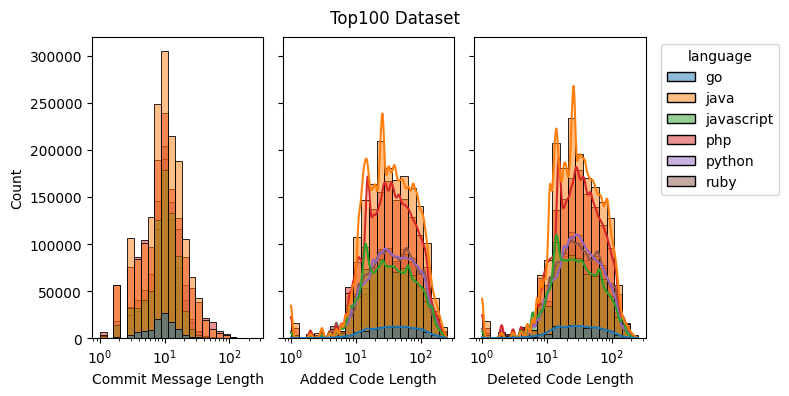

In [64]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 4), sharex=True, sharey=True)
h1 = sns.histplot(top100, x="msg", hue="language", ax=ax1, kde=True, stat="count", legend=False, log_scale=True, bins=20)
h2 = sns.histplot(top100, x="added", hue="language", ax=ax2, kde=True, stat="count", legend=False, log_scale=True, bins=20)
h3 = sns.histplot(top100, x="deleted", hue="language", ax=ax3, kde=True, stat="count", legend=True, log_scale=True, bins=20)
h2.set(ylabel=None)
h3.set(ylabel=None)
plt.setp(ax3.get_yticklabels(), visible=False)
sns.move_legend(h3, "upper left", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
ax1.set_xlabel("Commit Message Length")
ax2.set_xlabel("Added Code Length")
ax3.set_xlabel("Deleted Code Length")
fig.subplots_adjust(top=0.91)
fig.suptitle("Top100 Dataset")
plt.show()

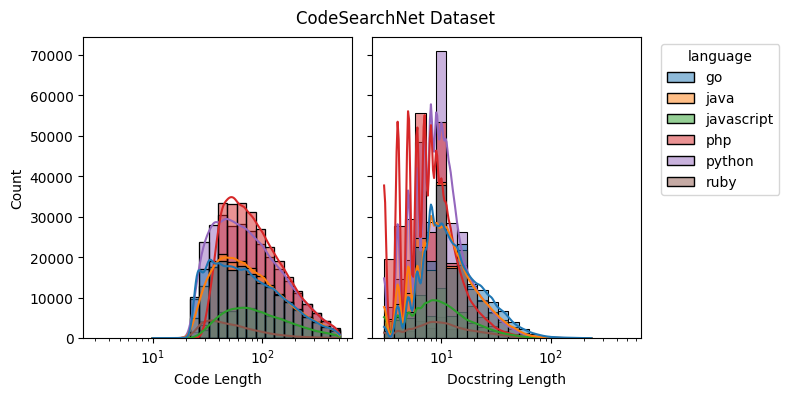

In [66]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharex=True, sharey=True)
h1 = sns.histplot(codesearchnet, x="code_tokens", hue="language", ax=ax1, kde=True, stat="count", legend=False, log_scale=True, bins=20)
h2 = sns.histplot(codesearchnet, x="docstring_tokens", hue="language", ax=ax2, kde=True, stat="count", legend=True, log_scale=True, bins=20)
h2.set(ylabel=None)
h3.set(ylabel=None)
plt.setp(ax3.get_yticklabels(), visible=False)
sns.move_legend(h2, "upper left", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
ax1.set_xlabel("Code Length")
ax2.set_xlabel("Docstring Length")
fig.subplots_adjust(top=0.91)
fig.suptitle("CodeSearchNet Dataset")
plt.show()

In [27]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(top100_distribution.describe())

index                                                          \
                count           mean            std  min        25%       50%   
language                                                                        
go           107999.0   44009.007500   29973.894338  0.0   16199.50   43199.0   
java        1687846.0  687796.405000  468440.674375  0.0  253176.25  675137.5   
javascript   739784.0  301460.970001  205317.842522  0.0  110966.75  295912.5   
php         1371018.0  558689.165000  380509.053582  0.0  205652.25  548406.5   
python       819094.0  333779.795000  227329.344423  0.0  122863.25  327636.5   
ruby         828017.0  337416.172500  229805.873867  0.0  124202.00  331206.0   

                                         msg                                  \
                   75%        max      count       mean        std  min  25%   
language                                                                       
go            70198.50    97198.0   107999.0  10.080121   5.901040  1.0  6.0   
java        1097098.75  1519060.0  1687846.0  11.985896   9.931081  0.0  6.0   
javascript   480858.25   665804.0   739784.0  10.401681   5.593212  0.0  7.0   
php          891160.75  1233915.0  1371018.0  12.420173  11.414636  0.0  6.0   
python       532409.75   737183.0   819094.0  11.525059   6.559288  0.0  7.0   
ruby         538210.00   745214.0   828017.0  10.428069   6.348643  0.0  6.0   

                                   added                                   \
             50%   75%    max      count       mean        std  min   25%   
language                                                                    
go           9.0  12.0  114.0   107999.0  50.977065  41.344741  1.0  19.0   
java        10.0  15.0  128.0  1687846.0  47.950670  40.094343  1.0  18.0   
javascript  10.0  13.0  128.0   739784.0  46.307899  39.975339  1.0  16.0   
php          9.0  15.0  128.0  1371018.0  46.668489  38.276640  1.0  18.0   
python      11.0  15.0  118.0   819094.0  50.718756  41.482987  1.0  19.0   
ruby         9.0  13.0  128.0   828017.0  49.026943  40.131940  1.0  19.0   

                                 deleted                                   \
             50%   75%    max      count       mean        std  min   25%   
language                                                                    
go          38.0  71.0  248.0   107999.0  40.496968  32.692467  1.0  16.0   
java        34.0  67.0  252.0  1687846.0  40.100121  32.424299  1.0  16.0   
javascript  32.0  64.0  251.0   739784.0  38.736658  33.352743  1.0  15.0   
php         34.0  64.0  252.0  1371018.0  40.876663  32.751275  1.0  17.0   
python      37.0  71.0  250.0   819094.0  41.359861  32.644390  1.0  18.0   
ruby        36.0  69.0  252.0   828017.0  41.170118  32.857502  1.0  17.0   

                              code_tokens                               \
             50%   75%    max       count mean std min 25% 50% 75% max   
language                                                                 
go          30.0  56.0  248.0         0.0  NaN NaN NaN NaN NaN NaN NaN   
java        29.0  55.0  247.0         0.0  NaN NaN NaN NaN NaN NaN NaN   
javascript  27.0  53.0  248.0         0.0  NaN NaN NaN NaN NaN NaN NaN   
php         30.0  55.0  250.0         0.0  NaN NaN NaN NaN NaN NaN NaN   
python      31.0  56.0  249.0         0.0  NaN NaN NaN NaN NaN NaN NaN   
ruby        30.0  57.0  249.0         0.0  NaN NaN NaN NaN NaN NaN NaN   

           docstring_tokens                               
                      count mean std min 25% 50% 75% max  
language                                                  
go                      0.0  NaN NaN NaN NaN NaN NaN NaN  
java                    0.0  NaN NaN NaN NaN NaN NaN NaN  
javascript              0.0  NaN NaN NaN NaN NaN NaN NaN  
php                     0.0  NaN NaN NaN NaN NaN NaN NaN  
python                  0.0  NaN NaN NaN NaN NaN NaN NaN  
ruby                    0.0  NaN NaN N